In [93]:
import pandas as pd
import numpy as np
import hvplot.pandas  # noqa
import matplotlib.pyplot as plt
import logging
import copy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# import lab_tools
import pickle
logging.basicConfig(level=logging.INFO)
import math
from scipy.constants import mu_0 as mu_0
from uncertainties import ufloat
import uncertainties
from uncertainties.umath import * 
from uncertainties import unumpy
from matplotlib import pyplot
import os

def uplot(x_ufloats, y_ufloats, ax=plt, **kwargs):
    getattr(ax, 'errorbar')
    plt.errorbar( unumpy.nominal_values(x_ufloats), unumpy.nominal_values(y_ufloats),
      xerr=unumpy.std_devs(x_ufloats), yerr= unumpy.std_devs(y_ufloats),ecolor='green',barsabove=True, **kwargs )


def load_pickle(name):
    with open(os.path.join('pickles',f'{name}.pickle'), 'rb') as handle:
        return pickle.load(handle)

def save_pickle(name, pick):
    if not os.path.exists('pickles'):
        os.makedirs('pickles')
    with open(os.path.join('pickles',f'{name}.pickle'), 'wb') as handle:
        return pickle.dump(pick,handle)

def load_state(state = 'state'):
    globals().update(load_pickle(state))

def save_state():
    data = {k:v for k,v in globals().items() if not k.startswith('_')}
    print(data)
    save_pickle('state', {k:v for k,v in globals().items() if not k.startswith('_')})

def malus_fit(x, a, b):
    return a * np.cos(x - b)**2

def clean_errors(df):
    return df.applymap(unumpy.nominal_values)

def genrate_fit_data(df, col, addition=10):
    max = unumpy.nominal_values(df[col].max())
    min = unumpy.nominal_values(df[col].min())
    return np.linspace(min - addition, max + addition, 100)


In [43]:
noise = ufloat(0.23,0.005) * 1e-3
df = pd.read_csv('data/2_poleraizers.csv')

In [44]:
power = []
for i in df['power']:
    power.append(ufloat(i, 0.005 * i) - noise) 
power = np.array(power)
df['power'] = power

In [45]:
angle = []
for i in df['angle']:
    angle.append(ufloat(i, 1/3))
angle = np.array(angle)
df['angle'] = angle * np.pi / 180

In [61]:
# df.to_csv('2_poleraizers.csv')
clean_errors(df).to_csv('2_poleraizers.csv')

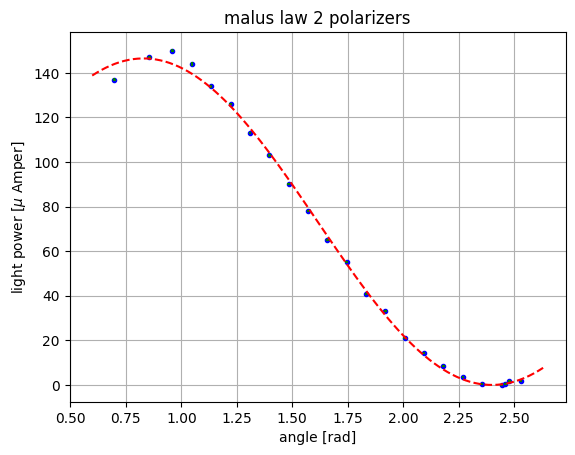

In [103]:
a = 146.48
b = 0.829046

#
# 

X = genrate_fit_data(df, 'angle', 0.1)

fig, ax = plt.subplots()
plot_data = uplot(df['angle'], df['power'], ax=ax, color='b', fmt='.')

pyplot.xlabel('angle'+' [rad]')
pyplot.ylabel('light power [$\mu$ Amper]')
pyplot.title('malus law 2 polarizers') 
# pyplot.xscale('log')
plt.grid()
plot_fit, = ax.plot(X, malus_fit(X, a, b), 'r--')

# im_ax = real_ax.twinx()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

# plt.legend([plot_real, plot_im, plot_real_fit, plot_im_fit], ['real part', 'imaginary part', 'real part fit', 'imaginary part fit'])

plt.savefig('images/malus_2_polerizers.svg', format='svg')
